In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터셋 삭제

In [ ]:
!rm -rf /content/dataset

# 데이터셋 불러오기

In [ ]:
!mkdir dataset
!unzip /content/drive/MyDrive/'datasets.zip' -d /content/dataset

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/dataset/L2_41/yxtxwawodpbozadexchs.jpg  
  inflating: /content/dataset/L2_41/pnfztlmerrrkqmeqqmme.jpg  
  inflating: /content/dataset/L2_41/nargedsqusnkzkfwxkje.jpg  
  inflating: /content/dataset/L2_41/szfqmropzcaevghrilke.jpg  
  inflating: /content/dataset/L2_41/dmqdwsedrcydkmniydlw.png  
  inflating: /content/dataset/L2_41/jhfbjiefvhimqhblihgj.jpg  
  inflating: /content/dataset/L2_41/erqrzkapkbjskpdgmgeh.jpg  
  inflating: /content/dataset/L2_41/issjlcvsyadjelkqdych.jpg  
  inflating: /content/dataset/L2_41/lhmtveghjnczgguytlqx.jpg  
  inflating: /content/dataset/L2_41/dzoinzzrxkktpyjgazmr.jpg  
  inflating: /content/dataset/L2_41/psjensoqzdgrmwwnmaop.jpg  
  inflating: /content/dataset/L2_41/akwgwqeazpoirdpdiplp.jpg  
  inflating: /content/dataset/L2_41/rgtvdtvohahvrtidkxps.jpg  
  inflating: /content/dataset/L2_41/nocnjcllyvpopxvpbqer.jpg  
  inflating: /content/dataset/L2_41/obwtgqsnstfogxrmlsca.jpg  
  inflating: /conte

# 정렬을 위해 L2_3에서 L2_03으로 이름 변경

In [ ]:
!mv /content/dataset/L2_3 /content/dataset/L2_03

mv: cannot stat '/content/dataset/L2_3': No such file or directory


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import glob
import PIL.ImageOps

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from tqdm import tqdm
import torchsummary
from torch import optim
from torch.optim.lr_scheduler import StepLR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import platform
from matplotlib import font_manager, rc
import warnings
warnings.filterwarnings("ignore")

if platform.system() == 'Windows':
# 윈도우인 경우 맑은 고딕 폰트 이용
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')

In [ ]:
datasets = os.listdir('/content/dataset')
datasets = sorted(datasets)
datasets

['L2_03',
 'L2_10',
 'L2_12',
 'L2_15',
 'L2_20',
 'L2_21',
 'L2_24',
 'L2_25',
 'L2_27',
 'L2_30',
 'L2_33',
 'L2_34',
 'L2_39',
 'L2_40',
 'L2_41',
 'L2_44',
 'L2_45',
 'L2_46',
 'L2_50',
 'L2_52']

# Mission 1 : 각 클래스별 데이터 분포 확인

In [ ]:
li = []
for i in datasets:
  li.append(len(os.listdir('dataset/{}'.format(i))))
li = np.array(li)
table = pd.DataFrame(li, index=datasets)
table.columns = ['len']
table

,len
L2_03,595
L2_10,1893
L2_12,518
L2_15,1509
L2_20,410
L2_21,410
L2_24,782
L2_25,6189
L2_27,426
L2_30,364


<BarContainer object of 20 artists>

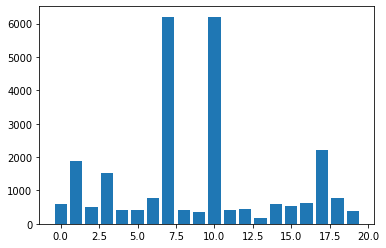

In [ ]:
class_id = list(range(20))
table['class_id'] = class_id
plt.bar(table.class_id, li)

## 실사이미지가 있는 class_id는 1, 2, 6, 14, 18 그리고 7, 10에서 데이터 분포 상으로 상대적으로 많은 데이터양, 4, 5, 8, 9, 11, 12, 13, 19가 500개 이하

# 이미지 경로 테이블 만들기

In [ ]:
img_path = []
for i in range(20):
  for j in os.listdir('/content/dataset/{}'.format(table.index[i])):
      img_path.append('/content/dataset/{}/{}'.format(table.index[i], j))
img_path = np.array(img_path)
path_table = pd.DataFrame(img_path, columns = ['image_name'])
path_table

,image_name
0,/content/dataset/L2_03/ipjhadqdoqppupccfpon.jpg
1,/content/dataset/L2_03/sasbnhtwjpfvajrpvexl.jpg
2,/content/dataset/L2_03/sxsnhzzkudznuiasasnh.jpg
3,/content/dataset/L2_03/xzebbxowotondtilchxf.png
4,/content/dataset/L2_03/hwxxbjzmwrxymjsntonr.png
...,...
25498,/content/dataset/L2_52/rcvexqzbbxudbyijmibd.jpg
25499,/content/dataset/L2_52/bvrlfuoijuwfedtujcyp.png
25500,/content/dataset/L2_52/hjwpdveewltzcdjarudy.jpg
25501,/content/dataset/L2_52/srrzwxctexgycpjdfffn.png


# Mission 2 : 실사와 일러스트 구분

## 이미지들을 (128, 128)의 크기로 재조정한 후 행렬 만들기

In [ ]:
image_li = []
for i in img_path:
  img = Image.open("{}".format(i)).convert('L')
  resize_img = img.resize((128, 128))
  x = np.array(resize_img)
  image_li.append(x)
image_li = np.array(image_li)

## 크기 조정한 이미지들은 3차원 배열이기에 KMeans 클러스터링을 위해 2차원 배열로 조정

In [ ]:
print(image_li.shape)
re_li = image_li.reshape(25503, -1)
re_li.shape

(25503, 128, 128)


(25503, 16384)

## KMeans 클러스터링을 사용하여 실사와 일러스트 구분

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
model = KMeans(n_clusters = 2, random_state = 10)
model.fit(re_li)
path_table['cluster'] = model.fit_predict(re_li)

## 실사와 일러스트 개수 확인

In [ ]:
path_table.cluster.value_counts()

1    23121
0     2382
Name: cluster, dtype: int64

## 더 수가 적은 클러스터 이미지들 삭제

In [ ]:
if path_table.cluster.value_counts()[0] > path_table.cluster.value_counts()[1]: 
  for i in path_table.loc[path_table.cluster == 1].image_name:
    os.remove(i)
else:
  for i in path_table.loc[path_table.cluster == 0].image_name:
    os.remove(i)

## 각 클래스별 분포 재확인

In [ ]:
li = []
for i in datasets:
  li.append(len(os.listdir('dataset/{}'.format(i))))
li = np.array(li)
table = pd.DataFrame(li, index=datasets)
table.columns = ['len']
table

,len
L2_03,202
L2_10,1776
L2_12,120
L2_15,1345
L2_20,398
L2_21,409
L2_24,416
L2_25,6112
L2_27,424
L2_30,363


<BarContainer object of 20 artists>

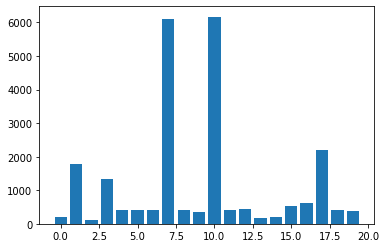

In [ ]:
class_id = list(range(20))
table['class_id'] = class_id
plt.bar(table.class_id, li)

# 줄어든 데이터의 이미지 경로 테이블 생성

In [ ]:
img_path = []
for i in range(20):
  for j in os.listdir('/content/dataset/{}'.format(table.index[i])):
      img_path.append('/content/dataset/{}/{}'.format(table.index[i], j))
img_path = np.array(img_path)
path_table = pd.DataFrame(img_path, columns = ['image_name'])
path_table

,image_name
0,/content/dataset/L2_03/sasbnhtwjpfvajrpvexl.jpg
1,/content/dataset/L2_03/xzebbxowotondtilchxf.png
2,/content/dataset/L2_03/hwxxbjzmwrxymjsntonr.png
3,/content/dataset/L2_03/dvwpwcvrljplafyijraa.png
4,/content/dataset/L2_03/vccqqblkbfekpfryzdyf.jpg
...,...
23116,/content/dataset/L2_52/rcvexqzbbxudbyijmibd.jpg
23117,/content/dataset/L2_52/bvrlfuoijuwfedtujcyp.png
23118,/content/dataset/L2_52/hjwpdveewltzcdjarudy.jpg
23119,/content/dataset/L2_52/srrzwxctexgycpjdfffn.png


# 이미지 경로별 클래스 부여

In [ ]:
a = []
for i in range(20):
  for _ in range(table.len[i]):
    a.append(i)

path_table['class'] = a
path_table

,image_name,class
0,/content/dataset/L2_03/sasbnhtwjpfvajrpvexl.jpg,0
1,/content/dataset/L2_03/xzebbxowotondtilchxf.png,0
2,/content/dataset/L2_03/hwxxbjzmwrxymjsntonr.png,0
3,/content/dataset/L2_03/dvwpwcvrljplafyijraa.png,0
4,/content/dataset/L2_03/vccqqblkbfekpfryzdyf.jpg,0
...,...,...
23116,/content/dataset/L2_52/rcvexqzbbxudbyijmibd.jpg,19
23117,/content/dataset/L2_52/bvrlfuoijuwfedtujcyp.png,19
23118,/content/dataset/L2_52/hjwpdveewltzcdjarudy.jpg,19
23119,/content/dataset/L2_52/srrzwxctexgycpjdfffn.png,19


# 언더샘플링(랜덤으로 이미지 삭제)

In [ ]:
for i in range(20):
  if table.len[i] < 1500:
    continue
  else:
    tmp = np.random.choice([i for i in range(table.len[i])], size=table.len[i]-1500, replace=False)
    for j in tmp:
      os.remove(path_table.loc[path_table['class']==i].reset_index().image_name[j])

# 각 클래스별 분포 재확인

In [ ]:
li = []
for i in datasets:
  li.append(len(os.listdir('dataset/{}'.format(i))))
li = np.array(li)
table = pd.DataFrame(li, index=datasets)
table.columns = ['len']
table

,len
L2_03,202
L2_10,1500
L2_12,120
L2_15,1345
L2_20,398
L2_21,409
L2_24,416
L2_25,1500
L2_27,424
L2_30,363


<BarContainer object of 20 artists>

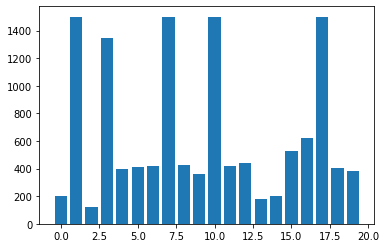

In [ ]:
class_id = list(range(20))
table['class_id'] = class_id
plt.bar(table.class_id, li)

# 오버샘플링(이미지 좌우 반전, 이미지 기울이기, 노이즈 추가)

In [ ]:
### 랜덤 시드 고정
import random
seed = 50
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

In [ ]:
num_augmented_images = 900

for i in os.listdir('/content/dataset'):
  file_path = ("/content/dataset/{}/".format(i))
  file_names = os.listdir(file_path)
  total_origin_image_num = len(file_names)
  augment_cnt = 1
  if total_origin_image_num > 1000:
    continue
  else:
    for i in range(num_augmented_images):
      change_picture_index = random.randrange(1, total_origin_image_num-1)
      print(change_picture_index)
      print(file_names[change_picture_index])
      file_name = file_names[change_picture_index]
      
      origin_image_path = file_path + "/" + file_name
      print(origin_image_path)
      image = Image.open(origin_image_path)
      random_augment = random.randrange(1,4)

      if(random_augment == 1):
      #이미지 좌우 반전
        print("invert")
        inverted_image = image.transpose(Image.FLIP_LEFT_RIGHT).convert("RGB")
        inverted_image.save(file_path + 'inverted_' + str(augment_cnt) + '.png')
          
      elif(random_augment == 2):
        #이미지 기울이기
        print("rotate")
        rotated_image = image.rotate(random.randrange(-20, 20)).convert("RGB")
        rotated_image.save(file_path + 'rotated_' + str(augment_cnt) + '.png')
              
      elif(random_augment == 3):
        #노이즈 추가하기
        img = np.array(Image.open(origin_image_path).convert("RGB"))
        print("noise")
        row,col,ch= img.shape
        mean = 0
        var = 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy_array = img + gauss
        noisy_image = Image.fromarray(np.uint8(noisy_array)).convert('RGB')
        noisy_image.save(file_path + 'noiseAdded_' + str(augment_cnt) + '.png')
              
      augment_cnt += 1

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
164
taygwsyqgybjgtchccoa.png
/content/dataset/L2_40//taygwsyqgybjgtchccoa.png
rotate
28
siwcepngfpjkjokeckza.jpg
/content/dataset/L2_40//siwcepngfpjkjokeckza.jpg
noise
152
oqtlxloutsmgpzoveoln.jpg
/content/dataset/L2_40//oqtlxloutsmgpzoveoln.jpg
noise
98
yzuhitfkzjkmfwpfwpem.jpg
/content/dataset/L2_40//yzuhitfkzjkmfwpfwpem.jpg
invert
152
oqtlxloutsmgpzoveoln.jpg
/content/dataset/L2_40//oqtlxloutsmgpzoveoln.jpg
rotate
177
jqyqrqiareggxgcodysj.jpg
/content/dataset/L2_40//jqyqrqiareggxgcodysj.jpg
invert
28
siwcepngfpjkjokeckza.jpg
/content/dataset/L2_40//siwcepngfpjkjokeckza.jpg
noise
53
addqarzmhtqkykardkec.png
/content/dataset/L2_40//addqarzmhtqkykardkec.png
rotate
155
yplflccplwvqgwxbqhcr.jpg
/content/dataset/L2_40//yplflccplwvqgwxbqhcr.jpg
rotate
176
texkqoyowaktlhlypokr.jpg
/content/dataset/L2_40//texkqoyowaktlhlypokr.jpg
invert
13
dkbnmljicvinglblmsva.jpg
/content/dataset/L2_40//dkbnmljicvinglblmsva.jpg
noise
171
yfriumarxhztnnpbfjca.jpg
/content/

In [ ]:
datasets = os.listdir('/content/dataset')
datasets = sorted(datasets)
datasets

['L2_03',
 'L2_10',
 'L2_12',
 'L2_15',
 'L2_20',
 'L2_21',
 'L2_24',
 'L2_25',
 'L2_27',
 'L2_30',
 'L2_33',
 'L2_34',
 'L2_39',
 'L2_40',
 'L2_41',
 'L2_44',
 'L2_45',
 'L2_46',
 'L2_50',
 'L2_52']

# 클래스별 데이터 분포 재확인

In [ ]:
li = []
for i in datasets:
  li.append(len(os.listdir('dataset/{}'.format(i))))
li = np.array(li)
table = pd.DataFrame(li, index=datasets)
table.columns = ['len']
table

,len
L2_03,1102
L2_10,1500
L2_12,1020
L2_15,1345
L2_20,1298
L2_21,1309
L2_24,1316
L2_25,1500
L2_27,1324
L2_30,1263


<BarContainer object of 20 artists>

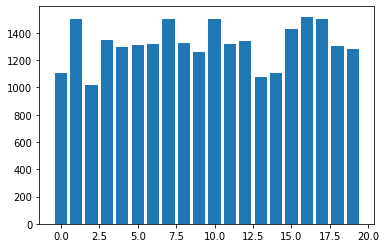

In [ ]:
class_id = list(range(20))
table['class_id'] = class_id
plt.bar(table.class_id, li)

# Mission 3 : 모델 구축

In [ ]:
dataset = ImageFolder(root='/content/dataset',
                      transform=transforms.Compose([
                          transforms.Resize((128, 128)),
                          transforms.ToTensor()
                          #transforms.Normalize((0.5,0.5,0.5), (0.25,0.25,0.25)
                    ]))
print(dataset.__len__())

26356


In [ ]:
def print_stats(dataset):
    imgs = np.array([img.numpy() for img, _ in dataset])
    print(f'shape: {imgs.shape}')
    
    min_r = np.min(imgs, axis=(2, 3))[:, 0].min()
    min_g = np.min(imgs, axis=(2, 3))[:, 1].min()
    min_b = np.min(imgs, axis=(2, 3))[:, 2].min()

    max_r = np.max(imgs, axis=(2, 3))[:, 0].max()
    max_g = np.max(imgs, axis=(2, 3))[:, 1].max()
    max_b = np.max(imgs, axis=(2, 3))[:, 2].max()

    mean_r = np.mean(imgs, axis=(2, 3))[:, 0].mean()
    mean_g = np.mean(imgs, axis=(2, 3))[:, 1].mean()
    mean_b = np.mean(imgs, axis=(2, 3))[:, 2].mean()

    std_r = np.std(imgs, axis=(2, 3))[:, 0].std()
    std_g = np.std(imgs, axis=(2, 3))[:, 1].std()
    std_b = np.std(imgs, axis=(2, 3))[:, 2].std()
    
    
    return mean_r, mean_g, mean_b, std_r, std_g, std_b

In [ ]:
mean_r, mean_g, mean_b, std_r, std_g, std_b = print_stats(dataset)
print(f'mean: {mean_r, mean_g, mean_b}')
print(f'std: {std_r, std_g, std_b}')

shape: (26356, 3, 128, 128)
mean: (0.8674418, 0.85420674, 0.84060097)
std: (0.094463415, 0.09110974, 0.09223583)


In [ ]:
dataset = ImageFolder(root='/content/dataset',
                      transform=transforms.Compose([
                          transforms.Resize((128, 128)),
                          transforms.ToTensor(),
                          transforms.Normalize((mean_r,mean_g,mean_b), (std_r,std_g,std_b)),
                        ]))
print(dataset.__len__())

26356


In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 26356
    Root location: /content/dataset
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.8674418, 0.85420674, 0.84060097), std=(0.094463415, 0.09110974, 0.09223583))
           )

In [ ]:
train_size = int(dataset.__len__() * 0.8)
valid_size = dataset.__len__() - train_size

training_data, valid_data = random_split(dataset, [train_size, valid_size])

train_sampler = torch.utils.data.RandomSampler(training_data)
valid_sampler = torch.utils.data.RandomSampler(valid_data)

In [ ]:
train_loader = DataLoader(training_data, batch_size=64, sampler=train_sampler)
valid_loader = DataLoader(valid_data, batch_size=64, sampler=valid_sampler)

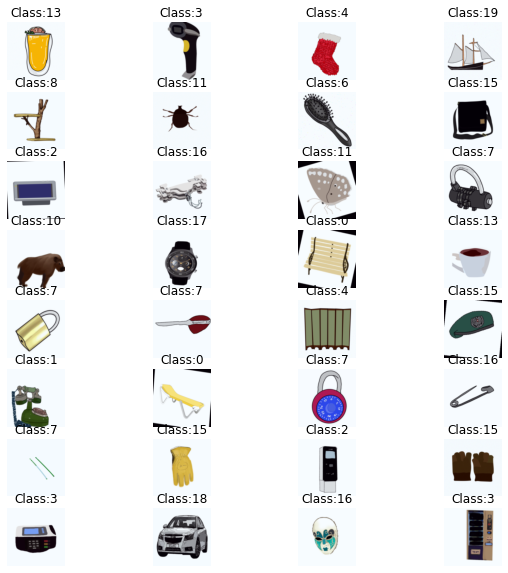

In [ ]:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
plt.figure(figsize=(10, 10))
images, labels = next(iter(train_loader))
for i in range(32):
  ax = plt.subplot(8, 4, i + 1)
  img = images[i]
  img = (img - img.min())/(img.max() - img.min())
  plt.imshow(img.permute(1, 2, 0).numpy())
  plt.title(f'Class:{class_names[labels[i]]}')
  plt.axis("off")

In [ ]:
class block(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=None,stride=1):
        super(block,self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)

        self.relu = nn.ReLU()
        self.downsample = downsample
        self.stride = stride

    def forward(self,x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.downsample is not None:
            identity = self.downsample(identity)
        
        x += identity
        x = self.relu(x)
        return x

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, image_channels=3, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 3,first_channels=64, stride=1)
        self.layer2 = self._make_layer(block, 4,first_channels=128, stride=2)
        self.layer3 = self._make_layer(block, 6,first_channels=256, stride=2)
        self.layer4 = self._make_layer(block, 3,first_channels=512, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0],-1)
        x = self.fc(x)
        return x

    def _make_layer(self, block, num_residual_blocks, first_channels, stride):
        downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != first_channels * 4:
            downsample = nn.Sequential(
                        nn.Conv2d(self.in_channels, first_channels * 4, kernel_size=1, stride=stride),
                        nn.BatchNorm2d(first_channels * 4)
                        )
        
        layers.append(
            block(self.in_channels, first_channels, downsample, stride)
        )

        self.in_channels = first_channels*4

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, first_channels))

        return nn.Sequential(*layers)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet(block, image_channels=3, num_classes=1000).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [ ]:
torchsummary.summary(model,input_size=(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,472
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,160
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,928
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,640
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,640
      BatchNorm2d-14          [-1, 256,

In [ ]:
### 학습 과정
epochs = 20
torch.cuda.empty_cache()
train_losses = []
val_losses = []
train_acc = []
val_acc = []
checkpoint = 1

for e in range(epochs):
    #training loop
    running_loss = 0
    running_accuracy = 0
    model.train()
    for _, data in enumerate(tqdm(train_loader)):   # tqdm <- progress bar
        # training phase
        inputs, labels = data
        inputs = inputs.to(device).float()
        labels = labels.to(device).long()
        optimizer.zero_grad() # reset gradient

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)

        # backward
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_accuracy += torch.sum(preds == labels.data).detach().cpu().numpy()/inputs.size(0)

    # validation loop
    model.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for _, data in enumerate(tqdm(valid_loader)):
            inputs, labels = data
            inputs = inputs.to(device).float()
            labels = labels.to(device).long()

            # forward
            outputs = model(inputs)
            _, preds = torch.max(outputs,1)

            # evaluation metrics
            # loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_accuracy += torch.sum(preds == labels.data).detach().cpu().numpy()/inputs.size(0)

        # calculate mean for each batch
        train_losses.append(running_loss/len(train_loader))
        val_losses.append(val_loss / len(valid_loader))
        train_acc.append(running_accuracy / len(train_loader))
        val_acc.append(val_accuracy / len(valid_loader))
        print("Epoch:{}/{}".format(e+1,epochs),
              "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
              "Val Loss: {:.3f}..".format(val_loss/len(valid_loader)),
              "Train Acc:{:.3f}..".format(running_accuracy/len(train_loader)),
              "Val Acc:{:.3f}..".format(val_accuracy/len(valid_loader)))
        
    torch.save(
        {
            "epoch": e,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "description": f"CustomModel 체크포인트_%d"%checkpoint,
        }, '/content/checkpoint_%d.pth'%checkpoint) # 각 epoch가 끝날 때마다 모델 상태 저장

    checkpoint += 1
        
history = {'train_loss': train_losses, 'val_loss': val_losses,
           'train_acc': train_acc,'val_acc': val_acc}

100%|██████████| 83/83 [04:27<00:00,  3.22s/it]


Epoch:1/20 Train Loss: 2.385.. Val Loss: 1.749.. Train Acc:0.289.. Val Acc:0.456..


100%|██████████| 83/83 [04:27<00:00,  3.22s/it]


Epoch:2/20 Train Loss: 1.291.. Val Loss: 1.083.. Train Acc:0.596.. Val Acc:0.660..


100%|██████████| 83/83 [04:25<00:00,  3.20s/it]


Epoch:3/20 Train Loss: 0.753.. Val Loss: 0.907.. Train Acc:0.761.. Val Acc:0.714..


100%|██████████| 83/83 [04:26<00:00,  3.21s/it]


Epoch:4/20 Train Loss: 0.440.. Val Loss: 0.756.. Train Acc:0.861.. Val Acc:0.769..


100%|██████████| 83/83 [04:26<00:00,  3.21s/it]


Epoch:5/20 Train Loss: 0.275.. Val Loss: 0.697.. Train Acc:0.913.. Val Acc:0.803..


100%|██████████| 83/83 [04:27<00:00,  3.22s/it]


Epoch:6/20 Train Loss: 0.187.. Val Loss: 0.544.. Train Acc:0.940.. Val Acc:0.836..


100%|██████████| 83/83 [04:27<00:00,  3.22s/it]


Epoch:7/20 Train Loss: 0.157.. Val Loss: 0.703.. Train Acc:0.951.. Val Acc:0.804..


100%|██████████| 83/83 [04:27<00:00,  3.22s/it]


Epoch:8/20 Train Loss: 0.143.. Val Loss: 0.683.. Train Acc:0.954.. Val Acc:0.814..


100%|██████████| 83/83 [04:27<00:00,  3.22s/it]


Epoch:9/20 Train Loss: 0.097.. Val Loss: 0.541.. Train Acc:0.970.. Val Acc:0.855..


100%|██████████| 83/83 [04:24<00:00,  3.18s/it]


Epoch:10/20 Train Loss: 0.087.. Val Loss: 0.620.. Train Acc:0.973.. Val Acc:0.839..


100%|██████████| 83/83 [04:26<00:00,  3.21s/it]


Epoch:11/20 Train Loss: 0.109.. Val Loss: 0.622.. Train Acc:0.965.. Val Acc:0.843..


100%|██████████| 83/83 [04:26<00:00,  3.21s/it]


Epoch:12/20 Train Loss: 0.089.. Val Loss: 0.461.. Train Acc:0.972.. Val Acc:0.876..


100%|██████████| 83/83 [04:26<00:00,  3.22s/it]


Epoch:13/20 Train Loss: 0.070.. Val Loss: 0.730.. Train Acc:0.976.. Val Acc:0.823..


100%|██████████| 83/83 [04:28<00:00,  3.23s/it]


Epoch:14/20 Train Loss: 0.087.. Val Loss: 0.621.. Train Acc:0.973.. Val Acc:0.845..


100%|██████████| 83/83 [04:28<00:00,  3.23s/it]


Epoch:15/20 Train Loss: 0.076.. Val Loss: 0.658.. Train Acc:0.976.. Val Acc:0.837..


100%|██████████| 83/83 [04:28<00:00,  3.24s/it]


Epoch:16/20 Train Loss: 0.063.. Val Loss: 0.586.. Train Acc:0.980.. Val Acc:0.857..


100%|██████████| 83/83 [04:28<00:00,  3.24s/it]


Epoch:17/20 Train Loss: 0.065.. Val Loss: 0.563.. Train Acc:0.980.. Val Acc:0.867..


100%|██████████| 83/83 [04:27<00:00,  3.22s/it]


Epoch:18/20 Train Loss: 0.069.. Val Loss: 0.515.. Train Acc:0.979.. Val Acc:0.870..


100%|██████████| 83/83 [04:26<00:00,  3.22s/it]


Epoch:19/20 Train Loss: 0.068.. Val Loss: 0.394.. Train Acc:0.977.. Val Acc:0.906..


100%|██████████| 83/83 [04:27<00:00,  3.23s/it]


Epoch:20/20 Train Loss: 0.032.. Val Loss: 0.381.. Train Acc:0.990.. Val Acc:0.912..


In [ ]:
### Test
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for _, data in enumerate(tqdm(valid_loader)):
        inputs, labels = data
        inputs = inputs.to(device).float()
        outputs = model(inputs)
        _, preds = torch.max(outputs,1)
        y_pred += list(preds.detach().cpu().numpy())
        y_true += list(labels.detach().numpy())

100%|██████████| 83/83 [04:28<00:00,  3.23s/it]


In [ ]:
### 예측 리포트
from sklearn.metrics import classification_report, confusion_matrix
print('\n Classification report \n\n',
      classification_report(
          y_true,
          y_pred,
           target_names=class_names
      )
      )


 Classification report 

               precision    recall  f1-score   support

           0       0.94      0.97      0.95       193
           1       0.91      0.89      0.90       303
           2       0.91      1.00      0.95       205
           3       0.82      0.92      0.87       290
           4       0.92      0.97      0.94       242
           5       0.93      0.84      0.88       290
           6       0.91      0.87      0.89       277
           7       0.93      0.88      0.91       274
           8       0.87      0.87      0.87       274
           9       0.94      0.83      0.88       269
          10       0.92      0.89      0.90       326
          11       0.95      0.92      0.94       250
          12       0.92      0.94      0.93       262
          13       0.99      0.98      0.99       183
          14       0.94      0.93      0.94       233
          15       0.88      0.93      0.91       294
          16       0.95      0.90      0.92       294


(<matplotlib.legend.Legend at 0x7f2a054e21d0>, None)

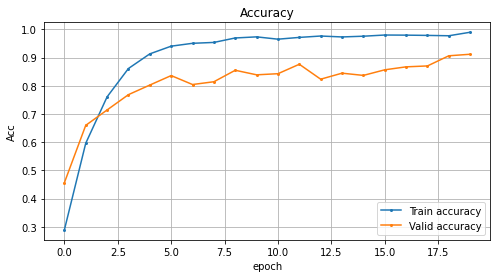

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history['train_acc'],marker='o',ms=2,label="Train accuracy")
plt.plot(history['val_acc'],marker='o',ms=2,label="Valid accuracy")
plt.title(f'Accuracy');
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend(), plt.grid()

(<matplotlib.legend.Legend at 0x7f2a0540da10>, None)

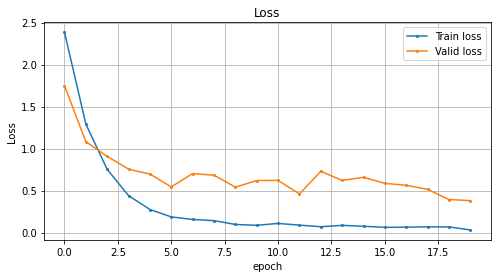

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history['train_loss'],marker='o',ms=2,label="Train loss")
plt.plot(history['val_loss'],marker='o',ms=2,label="Valid loss")
plt.title(f'Loss');
plt.ylabel('Loss');
plt.xlabel('epoch')
plt.legend(),plt.grid()